<!-- # Study B -->
This notebook shows the full workflow for building models, simulating growth and obtaining SCFA predictions from data collected by the _ex vivo_ study conducted by the Hamaker Lab in 2021 (Study B)

<!-- # Study B -->
This notebook shows the full workflow for building models, simulating growth and obtaining SCFA predictions from data collected by the _ex vivo_ study conducted by the Hamaker Lab in 2021 (Study B)

In [2]:
import pandas as pd
import numpy as np 
import os
import micom
import micom.measures
from plotnine import *
#import qiime2 as q2
import scipy

%matplotlib inline

## Flux Calculation
Here we will calculate production rate from the experimental SCFA measurements and convert them to dicts for later use

In [21]:
os.chdir("/proj/gibbons/nbohmann/exvivo/hamaker_2021/data/")
scfa = pd.read_csv("SCFA_forR_ correlation.csv") # read in GC-MS data
scfa['Acetate'] = scfa['Acetate']/4 # divide SCFA production by culturing time
scfa['Butyrate'] = scfa['Butyrate']/4
scfa['Propionate'] = scfa['Propionate']/4
scfa['Donor'] = scfa['Donor'].astype('str')
scfa['sample_id'] = scfa[['Treatment','Donor']].agg('_'.join, axis=1) # create sample ids with donor ID and treatment 
vals = scfa.groupby(scfa['sample_id']).cumcount().values# add replicate number
scfa['sample_id'] = (scfa['sample_id']+'_'+ (vals+1).astype(str))
scfa = scfa[(scfa.Treatment.str.contains('Blank'))|
            (scfa.Treatment.str.contains('Pectin'))|
            (scfa.Treatment.str.contains('FOS'))].set_index('sample_id') # isolate samples treated with pectin or controls
acetateMeasured = scfa['Acetate'].to_dict()
butyrateMeasured = scfa['Butyrate'].to_dict()
propionateMeasured = scfa['Propionate'].to_dict()
scfa

,Acetate,Propionate,Butyrate,Donor,Treatment
sample_id,,,,,
FOS_7_1,33.1375,6.1475,7.5175,7,FOS
FOS_8_1,29.1775,7.6575,4.9650,8,FOS
FOS_9_1,23.6550,6.7725,3.4775,9,FOS
FOS_10_1,22.2125,7.1000,6.9400,10,FOS
FOS_1_1,17.3625,5.2700,5.7400,1,FOS
...,...,...,...,...,...
Pectin_2_3,20.6650,2.2650,2.8225,2,Pectin
Pectin_3_3,18.3250,3.1950,1.7500,3,Pectin
Pectin_4_3,27.3350,4.1475,4.0775,4,Pectin


## Taxonomy Table
Next, we will read in abundance data for all samples. We will convert this into a taxnomy table to use in MICOM

In [26]:
abundance = pd.read_csv('/proj/gibbons/nbohmann/exvivo/hamaker_2021/data/hightha1perc_forR.csv') # Load the abundance
abundance['donor'] = abundance['donor'].astype('str')
abundance['sample_id'] = abundance[['treatment_II_B','donor']].agg(
    '_'.join, axis=1) # Join the treatment and donor into sample ID
abundance = abundance.drop(columns = ['treatment_II_B','donor'])
abundance.set_index('sample_id',inplace = True)
abundance = abundance.sort_index() #sort the index in order
abundance = abundance[~abundance.index.str.contains('II_')] # Remove the treatment without SCFA measurements
abundance.reset_index(inplace = True)
vals = abundance.groupby(abundance['sample_id']).cumcount().values# add replicate number
abundance['sample_id'] = (abundance['sample_id']+'_'+ (vals+1).astype(str))
abundance = pd.melt(abundance,
                    id_vars = 'sample_id', 
                    value_vars = abundance.columns[1:], 
                    var_name = 'id', 
                    value_name = 'abundance')
abundance['id'] = (abundance['id'].
                   str.replace('k__','').
                   str.replace('p__','').
                   str.replace('c__','').
                   str.replace('o__','').
                   str.replace('f__','').
                   str.replace('g__','').
                   str.replace('s__',''))
abundance['genus'] = abundance['id'].str.split(';').str[-2]
abundance = abundance[(abundance['sample_id'].str.contains('Blank'))|
                      (abundance['sample_id'].str.contains('Pectin'))|
                      (abundance['sample_id'].str.contains('FOS'))]
abundance['id'] = abundance['genus']
abundance = abundance.groupby(['sample_id','id','genus']).sum().reset_index().dropna()
abundance

,sample_id,id,genus,abundance
0,Blank_10_1,,,0.521327
1,Blank_10_1,Akkermansia,Akkermansia,0.000000
2,Blank_10_1,Anaerostipes,Anaerostipes,0.000000
3,Blank_10_1,Bacteroides,Bacteroides,33.566351
4,Blank_10_1,Bifidobacterium,Bifidobacterium,3.838863
...,...,...,...,...
1508,Pectin_9_3,Parabacteroides,Parabacteroides,1.946373
1509,Pectin_9_3,Roseburia,Roseburia,0.000000
1510,Pectin_9_3,Ruminococcus,Ruminococcus,2.803866
1511,Pectin_9_3,Succinivibrio,Succinivibrio,0.000000


In [28]:
pd.pivot_table(abundance, 
               index = 'sample_id',
               columns = 'genus',
               values = 'abundance').fillna(0.0).to_csv('/users/nbohmann/exvivo/studyB.csv')

## Build Models
Now, we'll build our models, with cutoff of 0.001

In [ ]:
manifest = micom.workflows.build(abundance,
                                 out_folder = '/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/models_collapsed/',
                                 model_db = '/proj/gibbons/refs/micom_dbs/agora103_genus.qza',
                                 cutoff = 0.001, 
                                 threads = 10)

In [ ]:
manifest = pd.read_csv('/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/mod

## Load Medium
Load in the carbon-stripped European Diet, and construct the intervention diets by augmenting with inulin and pectin

In [3]:
medium = pd.read_csv('/proj/gibbons/nbohmann/exvivo/diets/western_diet_depleted.csv')
medium['index'] = medium['reaction']
medium.set_index('index',inplace = True)
medium['flux'] = medium['flux']/10
medium.at['EX_h2o_m','flux']=100000

medium = pd.concat([medium, 
                    pd.DataFrame({'metabolite':['nh4_m', 
                                                'strch1_m', 'strch2_m','starch1200_m', 
                                                'dextrin_m','cellul_m'],
                                  'flux':[5,
                                          2, 2, 0.02,
                                          2, 0.00004],
                                  'reaction':['EX_nh4_m',
                                              'EX_strch1_m', 'EX_strch2_m', 'EX_starch1200_m', 
                                              'EX_dextrin_m', 'EX_cellul_m']},
                                 index = ['EX_nh4_m',
                                         'EX_strch1_m','EX_strch2_m', 'EX_starch1200_m',
                                         'EX_dextrin_m', 'EX_cellul_m'])])


controlMedium = medium

pectMedium = pd.concat([medium,
                           pd.DataFrame({'reaction':['EX_pect_m', 'EX_amylopect900_m'],
                                         'flux':[1,0]
                                        })]) 
fosMedium = pd.concat([medium,
                           pd.DataFrame({'reaction':['EX_kestopt_m', 'EX_kestottr_m', 'EX_kesto_m'],
                                         'flux':[100,100,100]
                                        })]) 
medium.to_csv('/users/nbohmann/exvivo/studyBmedium.csv')

## Grow Models
Now we'll grow the samples using the respective media we constructed

In [14]:
manifest = pd.read_csv('/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/models/manifest.csv')
controlManifest = manifest[manifest.sample_id.str.startswith('Blank')]
pectManifest = manifest[manifest.sample_id.str.startswith('Pect')]
fosManifest = manifest[manifest.sample_id.str.startswith('FOS')]
controlGrowth = micom.workflows.grow(controlManifest,
                                     '/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/models/',
                                     medium=controlMedium,
                                     tradeoff= 0.7, 
                                     strategy='none',
                                     threads = 10)

pectGrowth = micom.workflows.grow(pectManifest,
                                  '/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/models/',
                                  medium = pectMedium, 
                                  tradeoff = 0.7,
                                  strategy = 'none',
                                  threads = 20)

fosGrowth = micom.workflows.grow(fosManifest,
                                     '/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/models/',
                                     medium=fosMedium,
                                     tradeoff=0.7, 
                                     strategy='none',
                                     threads = 20)

Output()

Output()

Output()

## Compare SCFA Fluxes
We can now extract the production fluxes of SCFAs from each growth simulation, and construct a dataframe with both measured and predicted production rates.

In [15]:
controlProduction = micom.measures.production_rates(controlGrowth)
pectProduction = micom.measures.production_rates(pectGrowth)
fosProduction = micom.measures.production_rates(fosGrowth)

production = pd.concat([controlProduction, pectProduction,fosProduction])
scfas = production[(production['name']==('butyrate'))|
                   (production['name']==('acetate'))|
                   (production['name']==('propionate'))]


res = pd.pivot(scfas, index = 'sample_id',
                         columns = 'name',
                         values = 'flux')


res.rename(columns = {'acetate':'acetatePredicted',
                      'butyrate':'butyratePredicted',
                      'propionate':'propionatePredicted'
                      }, inplace = True
          )
res['acetateMeasured'] = res.index.map(acetateMeasured)
res['butyrateMeasured'] = res.index.map(butyrateMeasured)
res['propionateMeasured'] = res.index.map(propionateMeasured)
shannon = pd.read_csv('/proj/gibbons/nbohmann/exvivo/hamaker_2021/micom/shannon/alpha-diversity.tsv',
                      sep = '\t', index_col = 0)
shannon = shannon['shannon_entropy'].to_dict()
res['shannon'] = res.index.map(shannon)
res['treatment'] = res.index.str.split('_').str[0]
res['donor'] = res.index.str.split('_').str[1]
sem = res.groupby(['treatment','donor']).sem().reset_index()
sem['sample_id'] = sem['treatment']+'_'+sem['donor']
sem.set_index('sample_id', inplace = True)
sem = sem.rename(columns = {'acetatePredicted':'acetatePredictedSEM',
                      'butyratePredicted':'butyratePredictedSEM',
                      'propionatePredicted':'propionatePredictedSEM',
                      'acetateMeasured':'acetateMeasuredSEM',
                      'butyrateMeasured':'butyrateMeasuredSEM',             
                      'propionateMeasured':'propionateMeasuredSEM',
                      'shannon':'shannonSEM'})
res = res.groupby(['treatment','donor']).mean().reset_index()
res['sample_id'] = res['treatment']+'_'+res['donor']
res.set_index('sample_id', inplace = True)
res = pd.concat([res, sem], axis = 1).T.drop_duplicates().T
res[res.columns[2:]] = res[res.columns[2:]].astype('float')
res['treatment'] = res['treatment'].str.replace('Blank','Control')
res

name,treatment,donor,acetatePredicted,butyratePredicted,propionatePredicted,acetateMeasured,butyrateMeasured,propionateMeasured,shannon,acetatePredictedSEM,butyratePredictedSEM,propionatePredictedSEM,acetateMeasuredSEM,butyrateMeasuredSEM,propionateMeasuredSEM,shannonSEM
sample_id,,,,,,,,,,,,,,,,
Blank_1,Control,1,79.503670,13.278970,10.650439,1.216667,0.318333,0.278333,3.905067,4.496202,0.326359,0.197686,0.008457,0.002205,0.002205,0.011285
Blank_10,Control,10,64.966638,7.447669,47.373373,0.978333,0.183333,0.277500,2.823314,0.895065,0.362952,0.857774,0.007120,0.002205,0.002887,0.021297
Blank_2,Control,2,72.293075,14.712632,15.406365,1.462500,0.427500,0.331250,4.052904,6.128024,0.492541,0.614828,0.047500,0.015000,0.011250,0.065606
Blank_3,Control,3,75.241204,20.678703,12.398176,0.915833,0.195833,0.218333,3.861453,1.650700,0.164373,0.168358,0.034288,0.007949,0.009167,0.014606
Blank_4,Control,4,70.848903,18.978331,15.782751,1.401667,0.379167,0.447500,4.102260,3.274614,0.266992,0.147215,0.052843,0.016094,0.019094,0.012670
Blank_5,Control,5,90.050813,11.532238,13.898604,1.315000,0.441667,0.393333,3.655677,0.999790,0.450502,0.322662,0.026021,0.003005,0.003632,0.022891
Blank_6,Control,6,83.885393,17.187496,10.943347,1.040000,0.193333,0.255000,4.056686,5.060535,0.491800,0.130049,0.009465,0.002205,0.002887,0.010713
Blank_7,Control,7,76.654045,13.341340,18.644759,1.030000,0.236667,0.350000,3.177016,8.267528,1.542140,0.396479,0.013769,0.003632,0.007217,0.011400
Blank_8,Control,8,81.083572,12.793315,15.126961,1.277500,0.275833,0.355833,4.040074,8.931170,0.581123,2.707519,0.022546,0.004640,0.005833,0.004520


## Plot Results
Finally, we'll plot predicted vs measured fluxes against each other

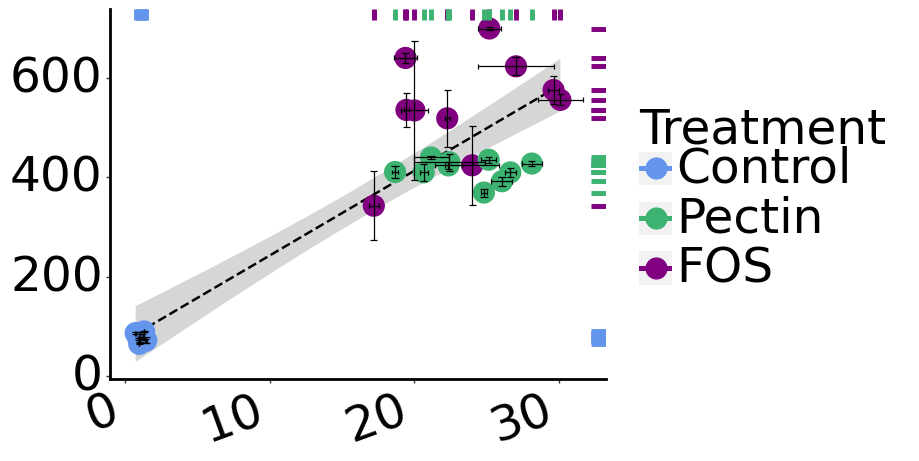

<ggplot: (8785424117047)>

In [16]:
fig1 = (ggplot(
    res, aes(x = 'acetateMeasured', y = 'acetatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_line(aes(groups = 'donor'))
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
    #              method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'acetateMeasured', 
                       ymin = 'acetatePredicted - acetatePredictedSEM',
                       ymax = 'acetatePredicted + acetatePredictedSEM'))
    +geom_errorbarh(aes(y = 'acetatePredicted', 
                       xmin = 'acetateMeasured - acetateMeasuredSEM',
                       xmax = 'acetateMeasured + acetateMeasuredSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +scale_fill_manual(limits = ['Control','Pectin', 'FOS'], 
                       values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig1

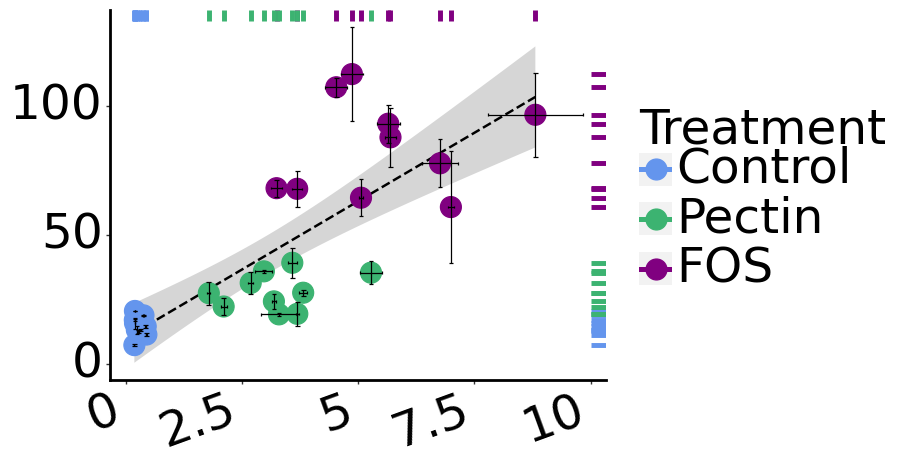

<ggplot: (8785436430698)>

In [17]:
fig2 = (ggplot(
    res, aes(x = 'butyrateMeasured', y = 'butyratePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_line(aes(groups = 'donor'))
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
    #              method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'butyrateMeasured', 
                       ymin = 'butyratePredicted - butyratePredictedSEM',
                       ymax = 'butyratePredicted + butyratePredictedSEM'), width = .1)
    +geom_errorbarh(aes(y = 'butyratePredicted', 
                       xmin = 'butyrateMeasured - butyrateMeasuredSEM',
                       xmax = 'butyrateMeasured + butyrateMeasuredSEM'), height = 1)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +scale_fill_manual(limits = ['Control','Pectin', 'FOS'], 
                       values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig2

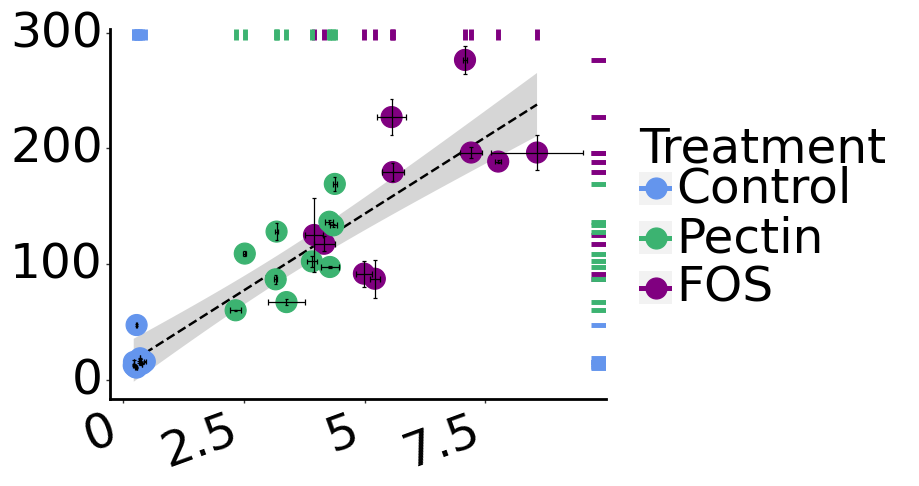

<ggplot: (8785421197060)>

In [18]:
fig3 = (ggplot(
    res, aes(x = 'propionateMeasured', y = 'propionatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_line(aes(groups = 'donor'))
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
    #              method = 'lm', linetype = '--', alpha = .5)
    +geom_errorbar(aes(x = 'propionateMeasured', 
                       ymin = 'propionatePredicted - propionatePredictedSEM',
                       ymax = 'propionatePredicted + propionatePredictedSEM'), width = .07)
    +geom_errorbarh(aes(y = 'propionatePredicted', 
                       xmin = 'propionateMeasured - propionateMeasuredSEM',
                       xmax = 'propionateMeasured + propionateMeasuredSEM'), height = 5)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +scale_fill_manual(limits = ['Control','Pectin', 'FOS'], 
                       values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig3

## Calculate Linear Regression

In [88]:
scipy.stats.linregress(res[res['treatment']=='Pectin']['acetatePredicted'],
                       res[res['treatment']=='Pectin']['acetateMeasured'])

LinregressResult(slope=0.004062912571833936, intercept=21.15003064754083, rvalue=0.05278267415356993, pvalue=0.884859041569847, stderr=0.027176609582855466, intercept_stderr=16.58175719730899)

In [122]:
scipy.stats.linregress(res['propionatePredicted'],
                       res['propionateMeasured'])

LinregressResult(slope=0.0316941462842332, intercept=0.1361897560068246, rvalue=0.9178498898093168, pvalue=9.39640945414993e-13, stderr=0.002590238554768212, intercept_stderr=0.3201701771415494)

## Calculate Treatment Group Differences

In [131]:
stat_micom, p_micom = scipy.stats.ttest_rel(res[res.index.str.contains('Pectin')]['propionatePredicted'],
                      res[res.index.str.contains('Blank')]['propionatePredicted'])
stat_exp, p_exp = scipy.stats.ttest_rel(res[res.index.str.contains('Pectin')]['propionateMeasured'],
                      res[res.index.str.contains('Blank')]['propionateMeasured'])
print('MICOM:'+str(p_micom))
print('Experimental:'+str(p_exp))

MICOM:1.4977126756671945e-06
Experimental:3.0058972300012813e-07


## Save Results

In [119]:
ggsave(fig1,'/users/nbohmann/studyBac.png', dpi = 300)
ggsave(fig2,'/users/nbohmann/studyBbut.png', dpi = 300)
ggsave(fig3,'/users/nbohmann/studyBppa.png', dpi = 300)

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /users/nbohmann/studyBac.png
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /users/nbohmann/studyBbut.png
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /users/nbohmann/studyBppa.png


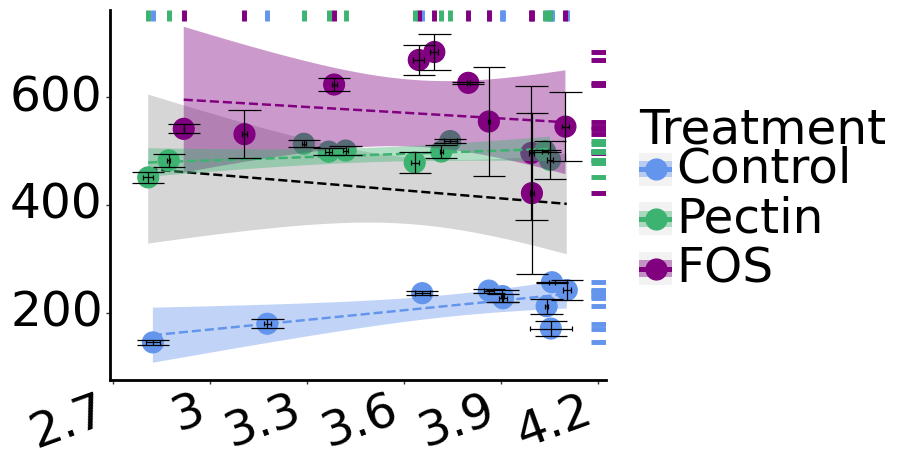

<ggplot: (8785424153513)>

In [7]:
fig4 = (ggplot(
    res, aes(x = 'shannon', y = 'acetatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_line(aes(groups = 'donor'))
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'shannon', 
                       ymin = 'acetatePredicted - acetatePredictedSEM',
                       ymax = 'acetatePredicted + acetatePredictedSEM'), width = .1)
    +geom_errorbarh(aes(y = 'acetatePredicted', 
                       xmin = 'shannon - shannonSEM',
                       xmax = 'shannon + shannonSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +scale_fill_manual(limits = ['Control','Pectin', 'FOS'], 
                       values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig4

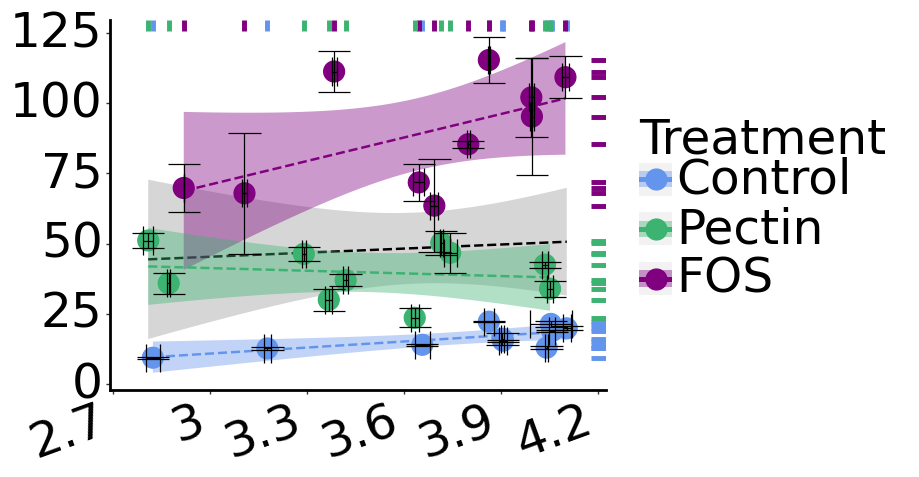

<ggplot: (8785423772164)>

In [8]:
fig5 = (ggplot(
    res, aes(x = 'shannon', y = 'butyratePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_line(aes(groups = 'donor'))
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'shannon', 
                       ymin = 'butyratePredicted - butyratePredictedSEM',
                       ymax = 'butyratePredicted + butyratePredictedSEM'), width = 0.1)
    +geom_errorbarh(aes(y = 'butyratePredicted', 
                       xmin = 'shannon - shannonSEM',
                       xmax = 'shannon + shannonSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +scale_fill_manual(limits = ['Control','Pectin', 'FOS'], 
                       values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig5

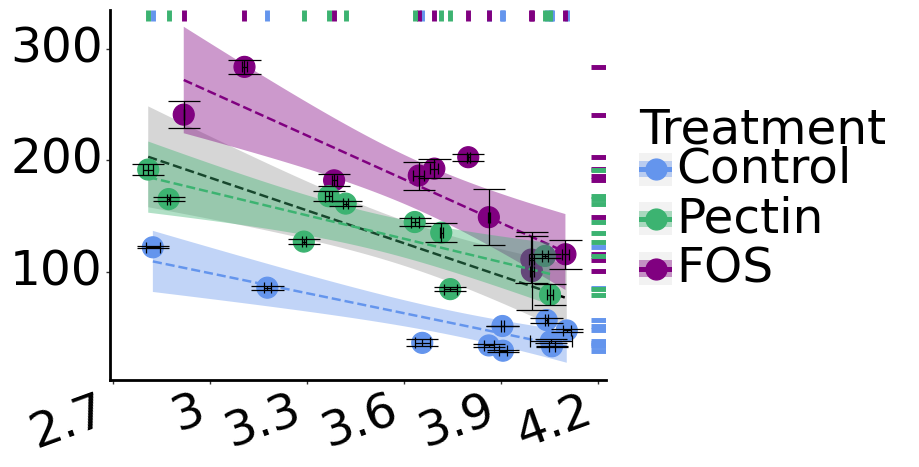

<ggplot: (8785429110935)>

In [9]:
fig6 = (ggplot(
    res, aes(x = 'shannon', y = 'propionatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_line(aes(groups = 'donor'))
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'shannon', 
                       ymin = 'propionatePredicted - propionatePredictedSEM',
                       ymax = 'propionatePredicted + propionatePredictedSEM'), width = 0.1)
    +geom_errorbarh(aes(y = 'propionatePredicted', 
                       xmin = 'shannon - shannonSEM',
                       xmax = 'shannon + shannonSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +scale_fill_manual(limits = ['Control','Pectin', 'FOS'], 
                       values = ['cornflowerblue', 'mediumseagreen', 'purple'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig6

In [53]:
ggsave(fig4,'/users/nbohmann/exvivo/2019_scfas/studyBacDiv.png', dpi = 300)
ggsave(fig5,'/users/nbohmann/exvivo/2019_scfas/studyBbutDiv.png', dpi = 300)
ggsave(fig6,'/users/nbohmann/exvivo/2019_scfas/studyBppaDiv.png', dpi = 300)

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /users/nbohmann/exvivo/2019_scfas/studyBacDiv.png
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /users/nbohmann/exvivo/2019_scfas/studyBbutDiv.png
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /users/nbohmann/exvivo/2019_scfas/studyBppaDiv.png


In [ ]:
consumption = micom.measures.consumption_rates(fosGrowth)

In [68]:
consumption[consumption.metabolite=='kestopt[e]']['flux'].describe()

count    30.000000
mean     59.942047
std       7.253048
min      46.676959
25%      54.906930
50%      60.073975
75%      64.967403
max      70.909492
Name: flux, dtype: float64

In [142]:
scfa['PPA+BUT'] = scfa['Butyrate']+scfa['Propionate']

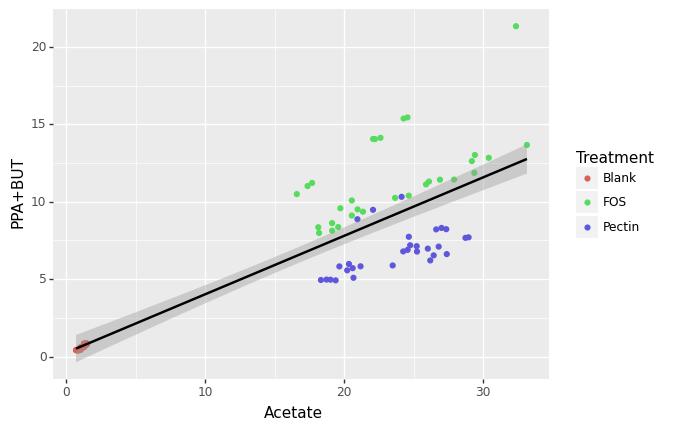

<ggplot: (8768295071678)>

In [152]:
emp_plot1 = (ggplot(
    scfa, aes(x = 'Acetate', y = 'PPA+BUT'))
            +geom_point(aes(color = 'Treatment'))
           +geom_smooth(method = 'lm'))
emp_plot1

In [19]:
res.to_csv('/proj/gibbons/nbohmann/exvivo/hamaker_2021/studyB.csv')

In [3]:
os.chdir("/proj/gibbons/nbohmann/exvivo/hamaker_2021/data/")
scfa = pd.read_csv("SCFA_forR_ correlation.csv") # read in GC-MS data
scfa

,Acetate,Propionate,Butyrate,Donor,Treatment
0,132.55,24.59,30.07,7,FOS
1,116.71,30.63,19.86,8,FOS
2,94.62,27.09,13.91,9,FOS
3,88.85,28.40,27.76,10,FOS
4,69.45,21.08,22.96,1,FOS
...,...,...,...,...,...
145,59.91,9.95,26.61,2,RS
146,79.15,16.49,9.96,3,RS
147,68.91,23.14,19.71,4,RS
148,104.52,22.04,36.15,5,RS
